### Ссылка на новостной источник: https://www.vpgazeta.ru/

**Задача**: используя библиотеку Natasha извлечь все названия организаций из текстов новостей. Построить граф социальной сети для организаций, упоминавшихся в новостях, считая, что две организации, встретившиеся в одной заметке связаны между собой. Рассчитать меру посредничества для вершин графа, выделить 10 вершин с самой большой мерой посредничества.

### 1. Получение ссылок на статьи

**1.1. Скачиваем и импортируем все, что понадобится**

In [1]:
!pip install natasha
!pip install selenium 

In [39]:
import re 
import operator
from natasha import (
    Segmenter,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    
    Doc
)
from natasha import NewsNERTagger
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

from pymystem3 import Mystem #для лемматизации названий организаций
m = Mystem()

import matplotlib.pyplot as plt #для построения графа
import networkx as nx

**1.2. Ищем доступ к новостям**

In [2]:
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get("https://www.vpgazeta.ru/")
hrefs = driver.find_elements_by_xpath("//a")  

In [3]:
article_urls = []
pn_url = ""
for hr in hrefs:
    url = hr.get_attribute("href")
    part_news_url = re.search(r"news$", url)
    if part_news_url == None:
        pass
    else:
        pn_url = url
print(pn_url)

https://www.vpgazeta.ru/part/news


Получив доступ к ссылке с новостями, мы увидим, что есть много страниц, на каждой из которых есть какое-то количество новостных статей. Поэтому нам нужно сначала достать ссылки на страницы, чтобы потом из них уже доставать статьи:

In [5]:
page_urls = []
driver_n = webdriver.Chrome('chromedriver', options=chrome_options)
driver_n.get(pn_url)
news_hrefs = driver_n.find_elements_by_xpath("//a")  
for hr in news_hrefs:
    url = hr.get_attribute("href")
    page_in_url = re.search(r"news\?", url)       
    if page_in_url == None:
        pass
    else:    
        print(url)
        page_urls.append(url)

https://www.vpgazeta.ru/part/news?srt=0&p=2
https://www.vpgazeta.ru/part/news?srt=0&p=6285


Для быстрого получения результата и его смыслоразличительной демонстации здесь будут рассмотрены новостные статьи с одной страницы (больше данных будет лежать в другой тетрадке).

In [6]:
all_pages = []
unvsl_str = page_urls[0][:-1]
end_str = page_urls[-1][-4:]
numb = int(end_str)
for i in range(2): #пополняем ссылками news...=0 и news...=1
    purl = f"{unvsl_str}{i}"
    all_pages.append(purl)
del all_pages[0]  #удалим news...=0, тк не существует
print(all_pages)

['https://www.vpgazeta.ru/part/news?srt=0&p=1']


Создадим пустой список **article_urls** и запишем туда ссылки со страницы:

In [7]:
%%time
article_urls = []
for page_url in all_pages:
    driver_p = webdriver.Chrome('chromedriver', options=chrome_options)
    driver_p.get(page_url)
    atcl_hrefs = driver_p.find_elements_by_xpath("//a")  
    for ahr in atcl_hrefs:
        url = ahr.get_attribute("href")
        article_in_url = re.search(r"article\/\d+", url)
        if article_in_url == None:
            pass
        else:
            article_urls.append(url)
print(article_urls)

['https://www.vpgazeta.ru/article/114966', 'https://www.vpgazeta.ru/article/114965', 'https://www.vpgazeta.ru/article/114964', 'https://www.vpgazeta.ru/article/114963', 'https://www.vpgazeta.ru/article/114962', 'https://www.vpgazeta.ru/article/114961', 'https://www.vpgazeta.ru/article/114960', 'https://www.vpgazeta.ru/article/114959', 'https://www.vpgazeta.ru/article/114958', 'https://www.vpgazeta.ru/article/114957', 'https://www.vpgazeta.ru/article/114956', 'https://www.vpgazeta.ru/article/114955']
Wall time: 7.58 s


### 2. Получение необходимых данных

Мы хотим создать файл, где с каждой новостной статьи будут лежать следующие данные:
* Url
* Название источника
* Дата
* Автор
* Название статьи
* Текст статьи

**2.1. Для удобства создадим себе отдельный файл с ссылками, чтобы при повторном запуске программы не пришлось заново находить ссылки:**

In [16]:
with open("demo_articles.txt", "w", encoding = "utf-8") as f:
    for element in article_urls:
        f.write(element)
        f.write('\n')

**2.2. Начнем собирать данные**

**Даты:**

In [17]:
with open("demo_articles.txt", "r", encoding = "utf-8") as f:
    urls = f.read()
    urls = urls.split('\n')
    del urls[-1]
    articles_dates = []
    for url in urls:
        driver_d = webdriver.Chrome('chromedriver', options=chrome_options)
        driver_d.get(url)
        dates = driver_d.find_elements_by_class_name("smaller2")
        for dt in dates:
            real_dt = dt.text
            articles_dates.append(real_dt)

In [18]:
articles_dts = []
re_dt = r"\d*\/\d*\/\d*"
for elem in articles_dates:
    res = re.search(re_dt, elem)
    if res == None:
        pass
    else:
        elem = elem.replace("/", ".")
        articles_dts.append(elem)
print(articles_dts)

['16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020', '16.10.2020']


**Названия статей:**

In [19]:
with open("demo_articles.txt", "r", encoding = "utf-8") as f:
    urls = f.read()
    urls = urls.split('\n')
    del urls[-1]
    articles_ts = []
    for url in urls:
        driver_t = webdriver.Chrome('chromedriver', options=chrome_options)
        driver_t.get(url)
        ts = driver_t.find_elements_by_xpath("//h1")
        for tl in ts:
            real_tl = tl.text
            articles_ts.append(real_tl)

In [13]:
print(articles_ts)

['В Марий Эл поступила вторая партия детской противогриппозной вакцины в количестве более 46 тыс доз', 'В Йошкар-Оле за сутки было зарегистрировано 29 новых случаев COVID-19', 'В Волжске за сутки зафиксировано 2 случая заражения коронавирусом, в Волжском районе - 5', 'Данные о количестве новых случаев заражения короновирусом в городах и районах Марий Эл на 16 октября', 'Эксперты ОНФ подняли проблему обеспечения школьников учебными пособиями', 'Годовая инфляция в Марий Эл в сентябре ускорилась', 'В Марий Эл в ближайшие выходные прогнозируют гололедицу и мокрый снег', 'В Марий Эл с начала пандемии из-за коронавируса умерло 59 человек', 'Строительство ФОКа в п.Приволжский (Марий Эл) близится к завершению', 'В Марий Эл за минувшие сутки выявлено 45 случаев заражения коронавирусом', 'В Марий Эл в п.Советский в ДТП пострадал 16-летний водитель мопеда', 'В Сернурском районе (Марий Эл) водитель Ford "улетел" в кювет']


**Тексты:**

In [20]:
with open("demo_articles.txt", "r", encoding = "utf-8") as f:
    urls = f.read()
    urls = urls.split('\n')
    del urls[-1]
    articles_texts = []
    for url in urls:
        driver_u = webdriver.Chrome('chromedriver', options=chrome_options)
        driver_u.get(url)
        texts = driver_u.find_elements_by_xpath("//span[@class='norm std']")
        add_ = []
        for tx in texts:
            real_text = tx.text
            add_.append(real_text)
        streal_text = ' '.join(add_)
        articles_texts.append(streal_text)

**Авторы:**

In [21]:
re_name = r"([А-Я][а-я]*\s[А-Я][а-я]*)"
names = []
for a_text in articles_texts:
    sth = []
    a_text = a_text.split()
    sth.append(a_text[0])
    sth.append(a_text[1])
    strh = ' '.join(sth)
    res = re.search(re_name, strh)
    if res == None:
        names.append("No name")
        pass
    else:
        doc = Doc(strh)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        doc.parse_syntax(syntax_parser)
        ner_tagger = NewsNERTagger(emb)
        doc.tag_ner(ner_tagger)
        ner_data = doc.ner
        for span in doc.spans:
            if span.type == 'PER':
                names.append(strh)
            else:
                names.append("No name")

**2.3. Запишем все в файл**

In [22]:
with open("demo_data.txt", "w", encoding = "utf-8") as f:
    for i in range(len(urls)):
        f.write('\n')
        f.write(urls[i])
        f.write('\n')
        f.write("Поволжская правда")
        f.write('\n')
        f.write(articles_dts[i])
        f.write('\n')
        f.write(names[i])
        f.write('\n')
        f.write(articles_ts[i])
        f.write('\n')
        f.write(articles_texts[i])
        f.write('\n')
        f.write('=====')

### 3. Достаем названия организаций

In [30]:
with open("demo_data.txt", "r", encoding = "utf-8") as f:
    data_news = f.read()
    data_news = data_news.split('=====')
    all_orgs = []
    for data_piece in data_news:
        orgs_inews = []
        data_piece = data_piece.split()
        for mostly_word in data_piece:
            doc = Doc(mostly_word)
            doc.segment(segmenter)
            doc.tag_morph(morph_tagger)
            doc.parse_syntax(syntax_parser)
            ner_tagger = NewsNERTagger(emb)
            doc.tag_ner(ner_tagger)
            ner_data = doc.ner
            for span in doc.spans:
                if span.type == 'ORG':
                    org = re.sub(r'[^\w\s\']','',doc.text)
                    orgs_inews.append(org)
        all_orgs.append(orgs_inews)
print(all_orgs)
            

[[], ['Роспотребнадзора'], ['Роспотребнадзора'], ['Роспотребнадзора', 'Оршанский'], ['ОНФ', 'ОНФ', 'ОНФ', 'ОНФ', 'Правительству'], ['Годовая', 'Годовая', 'Годовая', 'Меркурий', 'Годовая', 'Годовая', 'Годовая', 'Банка'], ['Марийского', 'ЦГМС', 'Филиала', 'ФГБУ', 'Верхне', 'Волжское', 'УГМС'], [], ['ФОКа', 'ФОКа', 'Волжского', 'Газпром', 'Трансгаз', 'ОАО', 'Газпрома', 'ООО', 'Газпром', 'ФОКа', 'Председателя', 'Правления', 'ПАО', 'Газпром', 'Волжского'], ['Роспотребнадзора'], [], ['Ford', 'ЙошкарОлаУржум', 'Ford'], []]


При просмотре текстов было видно, что в последнем кусочке есть названия (в данном случае 'Ford', 'ЙошкарОлаУржум', 'Ford'). Тем не менее в конце создавался ненужный пустой список. Его можно убрать.

In [31]:
if all_orgs[-1] == []:
    del all_orgs[-1]
print(all_orgs)

[[], ['Роспотребнадзора'], ['Роспотребнадзора'], ['Роспотребнадзора', 'Оршанский'], ['ОНФ', 'ОНФ', 'ОНФ', 'ОНФ', 'Правительству'], ['Годовая', 'Годовая', 'Годовая', 'Меркурий', 'Годовая', 'Годовая', 'Годовая', 'Банка'], ['Марийского', 'ЦГМС', 'Филиала', 'ФГБУ', 'Верхне', 'Волжское', 'УГМС'], [], ['ФОКа', 'ФОКа', 'Волжского', 'Газпром', 'Трансгаз', 'ОАО', 'Газпрома', 'ООО', 'Газпром', 'ФОКа', 'Председателя', 'Правления', 'ПАО', 'Газпром', 'Волжского'], ['Роспотребнадзора'], [], ['Ford', 'ЙошкарОлаУржум', 'Ford']]


**Будет лучше, если мы пролемматизируем полученные названия:**

In [32]:
news_orgs_lems = []
for news_orgs in all_orgs:
    str_news_orgs = ' '.join(news_orgs)
    orgs_lem = m.lemmatize(str_news_orgs)
    orgs_in1news = ' '.join(orgs_lem)
    orgs_in1news = orgs_in1news.split()
    news_orgs_lems.append(orgs_in1news)


### 4. Поиск связей и построение графа

In [33]:
def f(l):
    n = []
    for i in l:
        if i not in n:
            n.append(i)
    return n
def count_connection(some_li):
    i = 0
    total = []
    for i in range(len(some_li)-1):
        for el in some_li:
            cnctn_counter = 0
            data = []
            if el != some_li[i]:
                cnctn_counter += 1
                data.append(some_li[i])
                data.append(el)
                data.append(cnctn_counter)
                tup_data = tuple(data)
                total.append(tup_data)
    full_data = f(total)
    return full_data

cnctns = []
for oneworgs in news_orgs_lems:
    cnctn = count_connection(oneworgs)
    cnctns.append(cnctn)
for cnctn_list in cnctns:
    if cnctn_list == None:
        del cnctn_list
cnctns = [x for x in cnctns if x]
final_cnctns = []
for elem in cnctns:
    for tupletype in elem:
        final_cnctns.append(tupletype)
print(final_cnctns)    

[('роспотребнадзор', 'оршанский', 1), ('онф', 'правительство', 1), ('годовой', 'меркурий', 1), ('годовой', 'банка', 1), ('меркурий', 'годовой', 1), ('меркурий', 'банка', 1), ('марийский', 'ЦГМС', 1), ('марийский', 'филиал', 1), ('марийский', 'фгбу', 1), ('марийский', 'верхний', 1), ('марийский', 'волжский', 1), ('марийский', 'угмс', 1), ('ЦГМС', 'марийский', 1), ('ЦГМС', 'филиал', 1), ('ЦГМС', 'фгбу', 1), ('ЦГМС', 'верхний', 1), ('ЦГМС', 'волжский', 1), ('ЦГМС', 'угмс', 1), ('филиал', 'марийский', 1), ('филиал', 'ЦГМС', 1), ('филиал', 'фгбу', 1), ('филиал', 'верхний', 1), ('филиал', 'волжский', 1), ('филиал', 'угмс', 1), ('фгбу', 'марийский', 1), ('фгбу', 'ЦГМС', 1), ('фгбу', 'филиал', 1), ('фгбу', 'верхний', 1), ('фгбу', 'волжский', 1), ('фгбу', 'угмс', 1), ('верхний', 'марийский', 1), ('верхний', 'ЦГМС', 1), ('верхний', 'филиал', 1), ('верхний', 'фгбу', 1), ('верхний', 'волжский', 1), ('верхний', 'угмс', 1), ('волжский', 'марийский', 1), ('волжский', 'ЦГМС', 1), ('волжский', 'филиал'

10 вершин с самой большой мерой посредничества: [('угмс', 0.2608695652173913), ('фок', 0.34782608695652173), ('газпром', 0.34782608695652173), ('трансгаз', 0.34782608695652173), ('оао', 0.34782608695652173), ('ооо', 0.34782608695652173), ('председатель', 0.34782608695652173), ('правление', 0.34782608695652173), ('пао', 0.34782608695652173), ('волжский', 0.6086956521739131)]


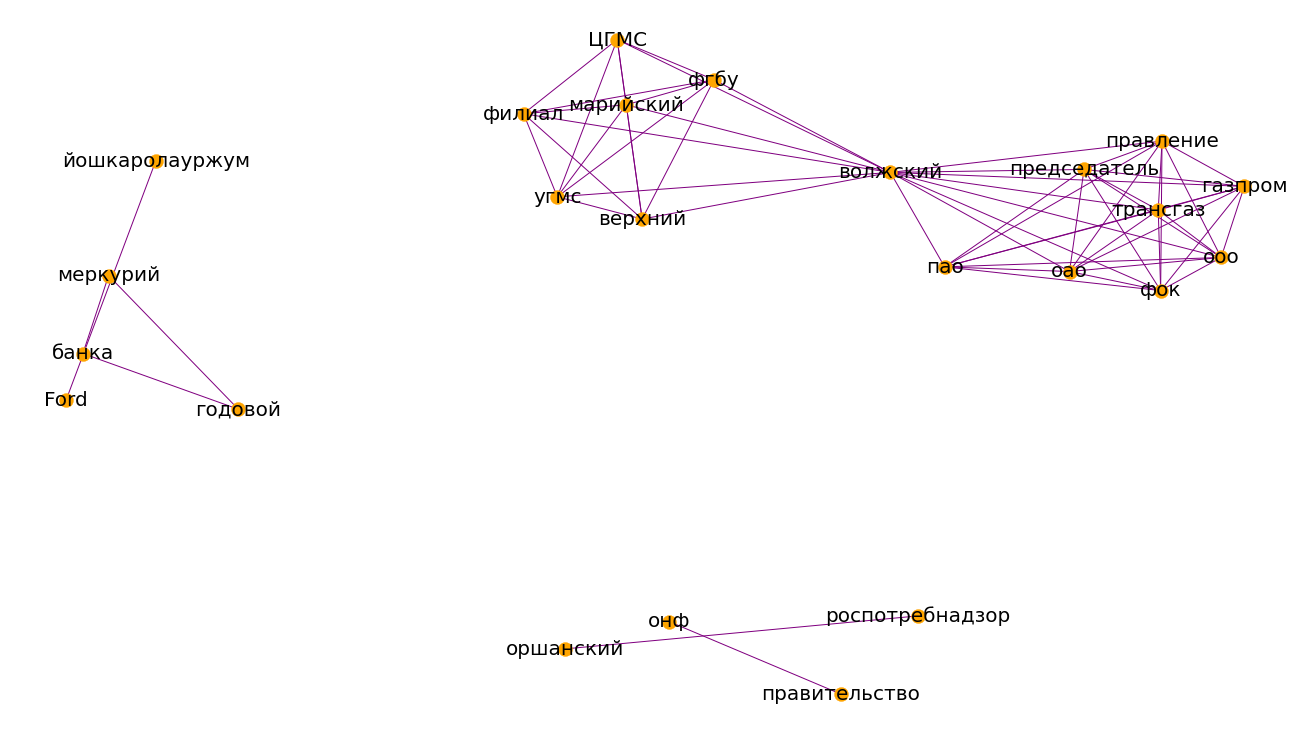

In [45]:
def buildGraph(data, thr = 0.):
    G1=nx.Graph()
    for edge_1, edge_2, w in data:
        if float(w) >= thr:
             G1.add_edge(edge_1, edge_2, penwidth=3.0, weight=10)
    return G1
def drawGraph(G):
#     pos=graphviz_layout(G)
    pos=nx.spring_layout(G,k=0.8,iterations=15)
    plt.figure(figsize=(18, 10)) #здесь можно регулировать ширину, длину размера графа
    _=nx.draw(G, pos, with_labels=True, node_color='orange', font_size=20, node_size = 200, linewidths=0.25, edge_cmap=plt.cm.Blues, edge_color='purple')
def buildAndDrawGraph(data, thr = 0.):
    G1 = buildGraph(final_cnctns, thr)
    drawGraph(G1)
    deg_cent = nx.degree_centrality(G1)
    sorted_dgcnt = sorted(deg_cent.items(), key=operator.itemgetter(1))
    top_10 = sorted_dgcnt[-10:] 
    print(f'10 вершин с самой большой мерой посредничества: {top_10}')
    return G1, top_10

res = buildAndDrawGraph(final_cnctns)
